<a href="https://colab.research.google.com/github/DingHsun/T-Brain-ChinaSteel-Competition/blob/main/%E4%B8%AD%E9%8B%BC%E7%AB%B6%E8%B3%BDcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 雲端載入資料

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq ./drive/My\ Drive/public_training_data.zip
!unzip -qq ./drive/My\ Drive/標記與資料說明.zip
!unzip -qq ./drive/My\ Drive/public_testing_data.zip
!unzip -qq ./drive/My\ Drive/submission_template.zip

# 自訂函數

##將 label 字串 encoding，embedding & un_embedding 兩個function

In [ ]:
char = [" ", "0", "1", "2", "3", "4", "5", "6", "7", "8",
     "9", "A", "B", "C", "D", "E", "F", "G", "H", "I",
     "J", "K", "L", "M", "N", "P", "Q", "R", "S", "T",
     "U", "V", "W", "X", "Y", "Z"]
char = {stu:i for i,stu in zip(range(len(char)),char)}
def embedding(label):
  embed = torch.zeros(16)
  j = 2
  for i in range(len(label)):
    if char[label[i]] == char[label[i-1]]:
      j += 1
    embed[j] = char[label[i]]
    j += 1
  return embed

def un_embedding(out):
  unembed = ""
  n = len(list(out))
  for i in range(n):
    if (out[i] != 0) & (out[i] != out[i-1]):
      unembed = unembed + list(char.keys())[list(char.values()).index(out[i])]
  return unembed

In [ ]:
import torch
print(embedding('440405506'))
un_embedding(torch.tensor([4., 5., 1., 5., 5., 5., 1., 6., 6., 1., 7., 0., 0., 0., 0.]))

tensor([0., 0., 5., 0., 5., 1., 5., 1., 6., 0., 6., 1., 7., 0., 0., 0.])


'34040506'

##評分函數

In [ ]:
from past.builtins import xrange

def levenshtein(s1, s2, key=hash):
  rows = costmatrix(s1, s2, key)
  edits = backtrace(s1, s2, rows, key)
  return rows[-1][-1], edits
from past.builtins import xrange
def costmatrix(s1, s2, key=hash):
  rows = []
  previous_row = xrange(len(s2) + 1)
  rows.append(list(previous_row))
  for i, c1 in enumerate(s1):
    current_row = [i + 1]
    for j, c2 in enumerate(s2):
      insertions = previous_row[j + 1] + 1
      deletions = current_row[j] + 1
      substitutions = previous_row[j] + (key(c1) != key(c2))
      current_row.append(min(insertions, deletions, substitutions))
    previous_row = current_row
    rows.append(previous_row)
  return rows
def backtrace(s1, s2, rows, key=hash):
  i, j = len(s1), len(s2)
  edits = []
  while(not (i == 0  and j == 0)):
    prev_cost = rows[i][j]
    neighbors = []
    if(i!=0 and j!=0):
      neighbors.append(rows[i-1][j-1])
    if(i!=0):
      neighbors.append(rows[i-1][j])
    if(j!=0):
      neighbors.append(rows[i][j-1])
    min_cost = min(neighbors)
    if(min_cost == prev_cost):
      i, j = i-1, j-1
      edits.append({'type':'match', 'i':i, 'j':j})
    elif(i!=0 and j!=0 and min_cost == rows[i-1][j-1]):
      i, j = i-1, j-1
      edits.append({'type':'substitution', 'i':i, 'j':j})
    elif(i!=0 and min_cost == rows[i-1][j]):
      i, j = i-1, j
      edits.append({'type':'deletion', 'i':i, 'j':j})
    elif(j!=0 and min_cost == rows[i][j-1]):
      i, j = i, j-1
      edits.append({'type':'insertion', 'i':i, 'j':j})
  edits.reverse()
  return edits
def lev(predicted, actual):
    #assert(len(predicted) == len(actual))
    total_dist = 0
    for pred, act in zip(predicted, actual):
        total_dist += levenshtein(pred, act)[0]
    return total_dist/max(len(predicted),1)
def score(pred_str,label_str):
  output = 0
  for p,l in zip(pred_str,label_str):
    try:
      output = output + 1-(p==l) + (1/len(pred_str))*(lev(p,l)/max(len(p),len(l)))
    except:
      output = output + 1-(p==l)
  return output

#資料前處理

##預測目標序號位置的「標框model」，(已前置訓練完畢)

In [ ]:
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.models as models

class MY_Model(nn.Module): 
  def __init__(self): 
    super().__init__()

    
    self.res = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-1])
    self.res[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    ct = 0
    for child in self.res.children():
      ct += 1
      if ct < 4:
        for param in child.parameters():
          param.requires_grad = False
    res_out = 512
    self.out = nn.Linear(res_out, 4)

  def forward(self, x): 
    if not isinstance(x, torch.Tensor):
      x = torch.Tensor(x)
    x = self.res(x)
    x = x.view(x.size(0),-1)#/255
    #x = torch.cat((x.mean(2),x.mean(3)),2)/100
    out = self.out(x)
    return out

#model_point = MY_Model_point()
#model_point = model_point.cuda()

In [ ]:
model_point = torch.load("picachu_model_標點model.pth")
model_point = model_point.cuda()

##「標框model」框出label並統一影像大小

In [ ]:
import csv
import os
import numpy as np
from PIL import Image
import torch
import cv2
from google.colab.patches import cv2_imshow
from numpy import newaxis
class public_data_getpoint(torch.utils.data.Dataset):
  def __init__(self, csv_file, mode='train', transform=None, c=(70, 450, 550, 320, 900, 8),transforms_point=None):

    self.mode = mode
    self.filename = []
    self.point = []
    self.label = []
    self.c = c
    self.transform = transform
    self.transforms_point = transforms_point

    if self.mode == 'test':
      with open(csv_file, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
          self.filename.append(row['id'])

    if self.mode == 'train':
      with open(csv_file, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
          self.filename.append(row['filename'])
          self.label.append(row['label'])

    if self.mode == 'val':
      with open(csv_file, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
          self.filename.append(row['filename'])
          self.label.append(row['label'])

  def __getitem__(self, index):

    if self.mode == 'test':
      picname = self.filename[index]
      file_pathname = "/content/public_testing_data"
      for picfilename in os.listdir(file_pathname):
        if self.filename[index] == picfilename[:-4]:
          data = cv2.imread(file_pathname+'/'+picfilename, cv2.IMREAD_GRAYSCALE)
          data = data[newaxis,:,:]
          data = torch.FloatTensor(data)
          cut_range, c1, c2, c3, c4, d = self.c
          data_ = data[:,c1-cut_range:c2+cut_range,c3-cut_range:c4+cut_range]
          data_ = self.transforms_point(data_)
          self.point = model_point(data_.resize(1,1,30,90).cuda()).resize(4)
          o1 = self.point[0]*d - cut_range + c3
          o2 = self.point[1]*d - cut_range + c1
          o3 = self.point[2]*d - cut_range + c3
          o4 = self.point[3]*d - cut_range + c1
          data = data[:,o2.int():o4.int(), o1.int():o3.int()]
          data = self.transform(data)
      return data, picname
      
    if self.mode == 'train':
      file_pathname = "/content/public_training_data/public_training_data"
      for picfilename in os.listdir(file_pathname):
        if self.filename[index] == picfilename[:-4]:
          data = cv2.imread(file_pathname+'/'+picfilename, cv2.IMREAD_GRAYSCALE)
          data = data[newaxis,:,:]
          data = torch.FloatTensor(data)
          cut_range, c1, c2, c3, c4, d = self.c
          data_ = data[:,c1-cut_range:c2+cut_range,c3-cut_range:c4+cut_range]
          data_ = self.transforms_point(data_)
          self.point = model_point(data_.resize(1,1,30,90).cuda()).resize(4)
          o1 = self.point[0]*d - cut_range + c3
          o2 = self.point[1]*d - cut_range + c1
          o3 = self.point[2]*d - cut_range + c3
          o4 = self.point[3]*d - cut_range + c1
          data = data[:,o2.int():o4.int(), o1.int():o3.int()]
          data = self.transform(data)
      label = torch.tensor(embedding(self.label[index]))
      return data, label

    if self.mode == 'val':
      file_pathname = "/content/public_training_data/public_testing_data"
      for picfilename in os.listdir(file_pathname):
        if self.filename[index] == picfilename[:-4]:
          data = cv2.imread(file_pathname+'/'+picfilename, cv2.IMREAD_GRAYSCALE)
          data = data[newaxis,:,:]
          data = torch.FloatTensor(data)
          cut_range, c1, c2, c3, c4, d = self.c
          data_ = data[:,c1-cut_range:c2+cut_range,c3-cut_range:c4+cut_range]
          data_ = self.transforms_point(data_)
          self.point = model_point(data_.resize(1,1,30,90).cuda()).resize(4)
          o1 = self.point[0]*d - cut_range + c3
          o2 = self.point[1]*d - cut_range + c1
          o3 = self.point[2]*d - cut_range + c3
          o4 = self.point[3]*d - cut_range + c1
          data = data[:,o2.int():o4.int(), o1.int():o3.int()]
          data = self.transform(data)
      label = torch.tensor(embedding(self.label[index]))
      return data, label

  def __len__(self):
    return len(self.filename)

In [ ]:
from torchvision import transforms
#c1, c2, c3, c4 = 450, 550, 320, 900
#cut_range = 70
#d = 8
transforms_point = transforms.Compose([
  transforms.Resize((int((c2-c1+2*cut_range)/d),int((c4-c3+2*cut_range)/d))),
  #transforms.ToTensor()
])

In [ ]:
from torchvision import transforms

transforms = transforms.Compose([
  #transforms.ToPILImage(),
  transforms.Resize((32,160)),
  #transforms.ToTensor()
])

##處理資料(train，val，test)

In [ ]:
dataset_train = public_data_getpoint('/content/Training Label/public_training_data.csv', mode='train', transform=transforms,transforms_point=transforms_point)
dataset_val = public_data_getpoint('/content/Training Label/public_testing_data.csv', mode='val', transform=transforms,transforms_point=transforms_point)
dataset_test = public_data_getpoint('/content/submission_template.csv', mode='test', transform=transforms,transforms_point=transforms_point)

In [ ]:
print("The first image's shape in dataset_train :", dataset_train.__getitem__(100)[0].size())
print("The first image's shape in dataset_train :", dataset_train.__getitem__(100)[0])
print("There are", dataset_train.__len__(), "images in dataset_train.")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


The first image's shape in dataset_train : torch.Size([1, 32, 160])
The first image's shape in dataset_train : tensor([[[65.2656, 72.9661, 76.5312,  ..., 55.0164, 53.2031, 53.6501],
         [69.8464, 77.8291, 79.4197,  ..., 53.8416, 55.8594, 54.4375],
         [75.9077, 79.8237, 82.7729,  ..., 55.7188, 58.5491, 60.1392],
         ...,
         [83.9368, 85.3728, 84.8391,  ..., 47.4724, 49.9219, 52.8296],
         [61.8491, 56.8433, 61.1384,  ..., 40.8728, 41.1169, 40.6562],
         [50.5286, 55.2786, 51.5461,  ..., 34.4524, 35.2942, 30.5374]]])
There are 12067 images in dataset_train.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


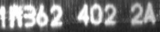

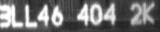

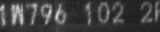

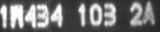

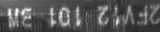

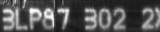

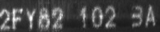

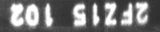

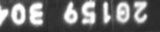

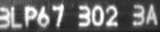

In [ ]:
for i in range(10):
  x = torch.tensor(dataset_val.__getitem__(i)[0])
  x = x.numpy().reshape(32,160)
  cv2_imshow(x)
  print("")

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset_train, batch_size=100, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset_val, batch_size=100, shuffle=False, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=100, shuffle=False, drop_last=False)

# 模型

##Resnet + GRU + ctc loss

In [ ]:
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.models as models

class MY_Model(nn.Module): 
  def __init__(self): 
    super().__init__()

    self.h_n = torch.zeros(2,100,256).cuda()    #(128, 1, 32, 160)
    #input_shape=(1,32,160)
    self.cnn_model = models.resnet50(pretrained=True)
    self.cnn_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False) #output_shape=(64,32,160)
    self.cnn_model.layer3[0].conv2 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False)
    self.cnn_model.layer3[0].downsample[0] =  nn.Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 1), bias=False)
    self.cnn_model.layer4[0].conv2 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False)
    self.cnn_model.layer4[0].downsample[0] = nn.Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 1), bias=False)
    self.cnn_model = nn.Sequential(*(list(self.cnn_model.children())[:-2]))
    ct = 0
    for child in self.cnn_model.children():
      ct += 1
      if ct < 5:
        for param in child.parameters():
          param.requires_grad = False
    self.maxpool = nn.MaxPool2d(kernel_size=(2, 1)) #output_shape=(512,1,40)
    #output_shape=(512,1,40)
    #output_shape=(512,40)
    self.gru1 = nn.GRU(input_size=2048, hidden_size=256, bidirectional=True)   #output_shape=(256,40)
    self.gru2 = nn.GRU(input_size=512, hidden_size=256, bidirectional=True)   #output_shape=(256,40)
    self.fc = nn.Linear(512, 36)

  def forward(self, x): 
    if not isinstance(x, torch.Tensor):
      x = torch.Tensor(x)
    out = self.cnn_model(x)
    out = self.maxpool(out)
    out = torch.squeeze(out, dim=2)              #output_shape=(128,512,40)
    out = out.permute(2, 0, 1)                #output_shape=(40,128,512)
    out, _ = self.gru1(out, self.h_n) #output_shape=(40,128,256)
    out, _ = self.gru2(out, self.h_n)           #output_shape=(40,128,256)
    out = self.fc(out)                     #output_shape=(40,128,36)
    return out

In [ ]:
model = torch.load("/content/picachu_model_gru.pth")
model = model.cuda()

In [ ]:
model = MY_Model()
model = model.cuda()
print(model)

MY_Model(
  (cnn_model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CTCLoss(blank=0)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = criterion.cuda()

In [ ]:
def train(input_data, model, criterion, optimizer):
  model.train()
  loss_list = []
  pred_str = []
  label_str = []
  for i, data in enumerate(input_data, 0):
    images, labels = data[0].cuda(), data[1].cuda()
    optimizer.zero_grad()
    outputs = model(images)
    outputs_ = outputs.log_softmax(2).cpu()
    loss = criterion(outputs_, labels, torch.full(size=(100,), fill_value=40, dtype=torch.long), torch.full(size=(100,), fill_value=16, dtype=torch.long))
    loss.backward()
    optimizer.step()
    outputs = outputs.argmax(2)
    for j in range(100):
      pred_str.append(un_embedding(outputs[:,j]))
      label_str.append(un_embedding(labels[j,:]))
    loss_list.append(loss)
  sco = score(pred_str,label_str)
  #sco = 0
  loss = sum(loss_list) / len(loss_list)
  return sco, loss

In [ ]:
def val(input_data, model, criterion):
  model.eval()
  loss_list = []
  pred_str = []
  label_str = []
  with torch.no_grad():
    for data in input_data:
      images, labels = data[0].cuda(), data[1].cuda()
      outputs = model(images)
      outputs_ = outputs.log_softmax(2).cpu()
      loss = criterion(outputs_, labels, torch.full(size=(100,), fill_value=40, dtype=torch.long), torch.full(size=(100,), fill_value=16, dtype=torch.long))
      outputs = outputs.argmax(2)
      for j in range(100):
        pred_str.append(un_embedding(outputs[:,j]))
        label_str.append(un_embedding(labels[j,:]))
      loss_list.append(loss)
  sco = score(pred_str,label_str)
  #sco = 0
  loss = sum(loss_list) / len(loss_list)
  return sco, loss

In [ ]:
import time
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [ ]:
max_epochs = 3
log_interval = 1
train_sco_list = []
train_loss_list = []
val_sco_list = []
val_loss_list = []

for epoch in range(1, max_epochs + 1):
  start_time = time.time()
  train_sco, train_loss = train(train_loader, model, criterion, optimizer)
  val_sco, val_loss = val(val_loader, model, criterion)
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  
  train_sco_list.append(train_sco)
  train_loss_list.append(train_loss)
  val_sco_list.append(val_sco)
  val_loss_list.append(val_loss)

  if epoch % log_interval == 0:
    print('=' * 20, 'Epoch', epoch, '=' * 20)
    print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')
    print('Train Sco: {:.6f} Train Loss: {:.6f}'.format(train_sco, train_loss))
    print('  Val Sco: {:.6f}   Val Loss: {:.6f}'.format(val_sco, val_loss))
  torch.save(model, "picachu_model_gru.pth")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


==================== Epoch 1 ====================
Epoch Time: 18m 1s
Train Sco: 11999.063510 Train Loss: 0.531485
  Val Sco: 6000.080358   Val Loss: 0.182095
==================== Epoch 2 ====================
Epoch Time: 18m 13s
Train Sco: 11932.064388 Train Loss: -0.141253
  Val Sco: 5890.053243   Val Loss: -0.273851
==================== Epoch 3 ====================
Epoch Time: 18m 23s
Train Sco: 11360.046739 Train Loss: -0.320943
  Val Sco: 5484.041252   Val Loss: -0.406308


In [ ]:
max_epochs = 3
log_interval = 1
train_sco_list = []
train_loss_list = []
val_sco_list = []
val_loss_list = []

for epoch in range(1, max_epochs + 1):
  start_time = time.time()
  train_sco, train_loss = train(train_loader, model, criterion, optimizer)
  val_sco, val_loss = val(val_loader, model, criterion)
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  
  train_sco_list.append(train_sco)
  train_loss_list.append(train_loss)
  val_sco_list.append(val_sco)
  val_loss_list.append(val_loss)

  if epoch % log_interval == 0:
    print('=' * 20, 'Epoch', epoch, '=' * 20)
    print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')
    print('Train Sco: {:.6f} Train Loss: {:.6f}'.format(train_sco, train_loss))
    print('  Val Sco: {:.6f}   Val Loss: {:.6f}'.format(val_sco, val_loss))
  torch.save(model, "picachu_model_gru.pth")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


==================== Epoch 1 ====================
Epoch Time: 18m 36s
Train Sco: 9613.034267 Train Loss: -0.526751
  Val Sco: 4323.030156   Val Loss: -0.587596
==================== Epoch 2 ====================
Epoch Time: 18m 49s
Train Sco: 8065.028210 Train Loss: -0.628813
  Val Sco: 3692.025042   Val Loss: -0.640870
==================== Epoch 3 ====================
Epoch Time: 19m 4s
Train Sco: 7115.024146 Train Loss: -0.684231
  Val Sco: 3337.022323   Val Loss: -0.712757


In [ ]:
max_epochs = 2
log_interval = 1
train_sco_list = []
train_loss_list = []
val_sco_list = []
val_loss_list = []

for epoch in range(1, max_epochs + 1):
  start_time = time.time()
  train_sco, train_loss = train(train_loader, model, criterion, optimizer)
  val_sco, val_loss = val(val_loader, model, criterion)
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  
  train_sco_list.append(train_sco)
  train_loss_list.append(train_loss)
  val_sco_list.append(val_sco)
  val_loss_list.append(val_loss)

  if epoch % log_interval == 0:
    print('=' * 20, 'Epoch', epoch, '=' * 20)
    print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')
    print('Train Sco: {:.6f} Train Loss: {:.6f}'.format(train_sco, train_loss))
    print('  Val Sco: {:.6f}   Val Loss: {:.6f}'.format(val_sco, val_loss))
  torch.save(model, "picachu_model_gru.pth")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


==================== Epoch 1 ====================
Epoch Time: 19m 5s
Train Sco: 6775.023063 Train Loss: -0.710209
  Val Sco: 3160.020945   Val Loss: -0.743402
==================== Epoch 2 ====================
Epoch Time: 19m 3s
Train Sco: 5828.020296 Train Loss: -0.756443
  Val Sco: 3151.022456   Val Loss: -0.742760


In [ ]:
max_epochs = 3
log_interval = 1
train_sco_list = []
train_loss_list = []
val_sco_list = []
val_loss_list = []

for epoch in range(1, max_epochs + 1):
  start_time = time.time()
  train_sco, train_loss = train(train_loader, model, criterion, optimizer)
  val_sco, val_loss = val(val_loader, model, criterion)
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  
  train_sco_list.append(train_sco)
  train_loss_list.append(train_loss)
  val_sco_list.append(val_sco)
  val_loss_list.append(val_loss)

  if epoch % log_interval == 0:
    print('=' * 20, 'Epoch', epoch, '=' * 20)
    print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')
    print('Train Sco: {:.6f} Train Loss: {:.6f}'.format(train_sco, train_loss))
    print('  Val Sco: {:.6f}   Val Loss: {:.6f}'.format(val_sco, val_loss))
  torch.save(model, "picachu_model_gru.pth")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


==================== Epoch 1 ====================
Epoch Time: 17m 37s
Train Sco: 5853.020342 Train Loss: -0.763153
  Val Sco: 2751.017454   Val Loss: -0.795688
==================== Epoch 2 ====================
Epoch Time: 17m 10s
Train Sco: 5798.020474 Train Loss: -0.776134
  Val Sco: 3078.022784   Val Loss: -0.749990
==================== Epoch 3 ====================
Epoch Time: 17m 10s
Train Sco: 5031.017269 Train Loss: -0.812558
  Val Sco: 2648.017506   Val Loss: -0.808113


In [ ]:
max_epochs = 3
log_interval = 1
train_sco_list = []
train_loss_list = []
val_sco_list = []
val_loss_list = []

for epoch in range(1, max_epochs + 1):
  start_time = time.time()
  train_sco, train_loss = train(train_loader, model, criterion, optimizer)
  val_sco, val_loss = val(val_loader, model, criterion)
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  
  train_sco_list.append(train_sco)
  train_loss_list.append(train_loss)
  val_sco_list.append(val_sco)
  val_loss_list.append(val_loss)

  if epoch % log_interval == 0:
    print('=' * 20, 'Epoch', epoch, '=' * 20)
    print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')
    print('Train Sco: {:.6f} Train Loss: {:.6f}'.format(train_sco, train_loss))
    print('  Val Sco: {:.6f}   Val Loss: {:.6f}'.format(val_sco, val_loss))
  torch.save(model, "picachu_model_gru.pth")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


==================== Epoch 1 ====================
Epoch Time: 17m 13s
Train Sco: 4830.016704 Train Loss: -0.806223
  Val Sco: 2324.015011   Val Loss: -0.829546
==================== Epoch 2 ====================
Epoch Time: 17m 0s
Train Sco: 4595.015084 Train Loss: -0.838785
  Val Sco: 2266.014507   Val Loss: -0.839882
==================== Epoch 3 ====================
Epoch Time: 16m 55s
Train Sco: 3902.012229 Train Loss: -0.870358
  Val Sco: 2084.013363   Val Loss: -0.845497


In [ ]:
max_epochs = 5
log_interval = 1
train_sco_list = []
train_loss_list = []
val_sco_list = []
val_loss_list = []

for epoch in range(1, max_epochs + 1):
  start_time = time.time()
  train_sco, train_loss = train(train_loader, model, criterion, optimizer)
  val_sco, val_loss = val(val_loader, model, criterion)
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  
  train_sco_list.append(train_sco)
  train_loss_list.append(train_loss)
  val_sco_list.append(val_sco)
  val_loss_list.append(val_loss)

  if epoch % log_interval == 0:
    print('=' * 20, 'Epoch', epoch, '=' * 20)
    print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')
    print('Train Sco: {:.6f} Train Loss: {:.6f}'.format(train_sco, train_loss))
    print('  Val Sco: {:.6f}   Val Loss: {:.6f}'.format(val_sco, val_loss))
  torch.save(model, "picachu_model_gru.pth")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


==================== Epoch 1 ====================
Epoch Time: 17m 13s
Train Sco: 3686.011575 Train Loss: -0.865538
  Val Sco: 2113.013537   Val Loss: -0.852952
==================== Epoch 2 ====================
Epoch Time: 16m 40s
Train Sco: 3165.009826 Train Loss: -0.894063
  Val Sco: 1793.010916   Val Loss: -0.880436
==================== Epoch 3 ====================
Epoch Time: 16m 42s
Train Sco: 2903.009078 Train Loss: -0.909201
  Val Sco: 1933.011784   Val Loss: -0.877764
==================== Epoch 4 ====================
Epoch Time: 16m 39s
Train Sco: 2774.008801 Train Loss: -0.909163
  Val Sco: 1542.008950   Val Loss: -0.894874
==================== Epoch 5 ====================
Epoch Time: 16m 36s
Train Sco: 2940.009671 Train Loss: -0.910986
  Val Sco: 1951.012229   Val Loss: -0.876247


In [ ]:
max_epochs = 3
log_interval = 1
train_sco_list = []
train_loss_list = []
val_sco_list = []
val_loss_list = []

for epoch in range(1, max_epochs + 1):
  start_time = time.time()
  train_sco, train_loss = train(train_loader, model, criterion, optimizer)
  val_sco, val_loss = val(val_loader, model, criterion)
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  
  train_sco_list.append(train_sco)
  train_loss_list.append(train_loss)
  val_sco_list.append(val_sco)
  val_loss_list.append(val_loss)

  if epoch % log_interval == 0:
    print('=' * 20, 'Epoch', epoch, '=' * 20)
    print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')
    print('Train Sco: {:.6f} Train Loss: {:.6f}'.format(train_sco, train_loss))
    print('  Val Sco: {:.6f}   Val Loss: {:.6f}'.format(val_sco, val_loss))
  torch.save(model, "picachu_model_gru.pth")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


==================== Epoch 1 ====================
Epoch Time: 16m 38s
Train Sco: 2927.009284 Train Loss: -0.902851
  Val Sco: 1686.009629   Val Loss: -0.875519
==================== Epoch 2 ====================
Epoch Time: 16m 41s
Train Sco: 2514.008059 Train Loss: -0.924481
  Val Sco: 1496.009899   Val Loss: -0.910117
==================== Epoch 3 ====================
Epoch Time: 17m 2s
Train Sco: 2288.007525 Train Loss: -0.937600
  Val Sco: 1383.008778   Val Loss: -0.910447


In [ ]:
max_epochs = 3
log_interval = 1
train_sco_list = []
train_loss_list = []
val_sco_list = []
val_loss_list = []

for epoch in range(1, max_epochs + 1):
  start_time = time.time()
  train_sco, train_loss = train(train_loader, model, criterion, optimizer)
  val_sco, val_loss = val(val_loader, model, criterion)
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  
  train_sco_list.append(train_sco)
  train_loss_list.append(train_loss)
  val_sco_list.append(val_sco)
  val_loss_list.append(val_loss)

  if epoch % log_interval == 0:
    print('=' * 20, 'Epoch', epoch, '=' * 20)
    print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')
    print('Train Sco: {:.6f} Train Loss: {:.6f}'.format(train_sco, train_loss))
    print('  Val Sco: {:.6f}   Val Loss: {:.6f}'.format(val_sco, val_loss))
  torch.save(model, "picachu_model_gru.pth")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


==================== Epoch 1 ====================
Epoch Time: 17m 52s
Train Sco: 3068.011234 Train Loss: -0.886488
  Val Sco: 1825.012535   Val Loss: -0.880946
==================== Epoch 2 ====================
Epoch Time: 17m 50s
Train Sco: 2486.008802 Train Loss: -0.925317
  Val Sco: 1193.007319   Val Loss: -0.922759
==================== Epoch 3 ====================
Epoch Time: 17m 52s
Train Sco: 2631.008641 Train Loss: -0.935075
  Val Sco: 1869.011808   Val Loss: -0.880018


##訓練過程之score and loss

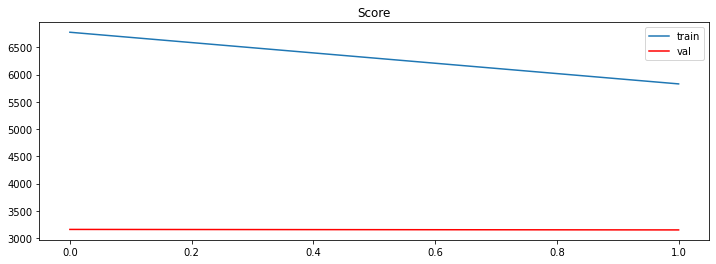

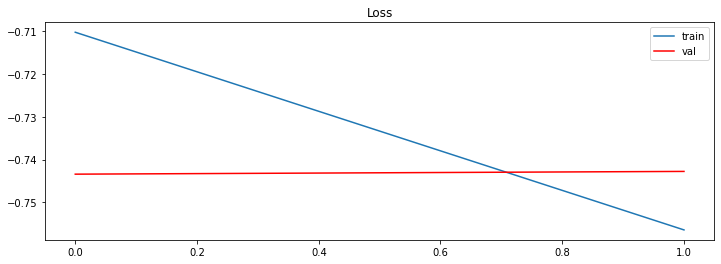

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_sco_list)), train_sco_list)
plt.plot(range(len(val_sco_list)), val_sco_list, c='r')
plt.legend(['train', 'val'])
plt.title('Score')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()

# 預測

In [ ]:
def predict(input_data, model):
  model.eval()
  output_list = []
  pred_str = []
  label_str = []
  with torch.no_grad():
    for data in input_data:
      images = data[0].cuda()
      outputs = model(images)
      outputs = outputs.argmax(2)
      outputs = outputs.permute(1,0)
      for i in range(outputs.size(0)):
        output_list.append(un_embedding(outputs[i]))
  return output_list

# 輸出

In [ ]:
output_csv = predict(test_loader, model)
picname_csv = []
with open("/content/submission_template.csv", newline='') as csvfile:
  reader = csv.DictReader(csvfile)
  for row in reader:
    picname_csv.append(row['id'])
with open('result.csv', 'w', newline='') as csvFile:
  writer = csv.DictWriter(csvFile, fieldnames=['id', 'text'])
  writer.writeheader()
  for i in range(len(output_csv)):
    writer.writerow({'id':picname_csv[i], 'text':output_csv[i]})

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
